This script is used to 1.) test the code I use for the HPC sh scripts and 2.) read in the HPC-generated permutation files.

In [ ]:
#Load libraries 
import pandas as pd
import os
import pickle

In [ ]:
#Download the observed test statistics
df = pd.read_csv('../Data/permutation_test_files_metabolomics/observed_tstats.csv', index_col=0)
#df = pd.read_csv('../Data/permutation_test_files_proteomics/observed_tstats.csv', index_col=0)


### Reading in the files

In [ ]:
os.getcwd()

In [ ]:
path = os.getcwd()[:-13] + '\\Data\\permutation_test_files_metabolomics'
#path = os.getcwd()[:-13] + '\\Data\\permutation_test_files_proteomics'
#path = os.getcwd()[:-13] + '\\Data\\permutation_test_files_integrated'

Read all the files that start with 'Run' inside a folder:

In [ ]:
final_list = []

for filename in os.listdir(path): #also lists directories
    if filename.startswith('Run'):
        file_num = int(filename[3:-4])  #obtain the number of the Run
        if file_num < 11:
            print(filename)
            with open(os.path.join(path, filename), 'rb') as file: #open in readonly mode
                list1 = pickle.load(file)
            final_list.append(list1)

Read all the files in a folder that starts with 'Results':

In [ ]:
final_list = []

for filename in os.listdir(path): #also lists directories
    if filename.startswith('Results'):
        print(filename)
        #for file in os.listdir(path + '\\' + filename): 
        for file in os.listdir(os.path.join(path,filename)):
            print(file)
            with open(os.path.join(path, filename,file), 'rb') as file: # open in readonly mode
                list1 = pickle.load(file)
            final_list.append(list1)

In a folder with directories list (Results1, Results2, Results3 etc) go through each as a separate array job:


In [ ]:
#index_num = sys.argv[1]  #in a sh script for the HPC, this should return the array number within the array job
index_num = 1 #for example
path = os.getcwd()[:-13] + '\\Data\\permutation_test_files_metabolomics\\Results' + str(index_num)
final_list = []

for filename in os.listdir(path): #also lists directories
    print(filename)
    with open(os.path.join(path, filename), 'rb') as file: # open in readonly mode
        list1 = pickle.load(file)
    final_list.append(list1)

In [ ]:
print(len(final_list))

for list1 in final_list:
    print(len(list1))
    print(list1[:3])

### Calculate which edges are significant

Calculates number of permuted values above the observed test statistic, then divides by number of tests and works out p-value, before outputting the significant edges. THIS APPROACH IS NOT RECOMMENDED, because p-values not FDR corrected. Instead, it is better to output the number of permuted values above the observed test statistic ONLY.

In [ ]:
sig_edges = []
edgelist = df.index

for index,pathway_pair in enumerate(edgelist):   #test all pathways
    comparison = df.Observed_tstat[index]    #get observed test statistic
    counter = 0

    if comparison >= 0:
        for list1 in final_list:  #len(final_list) = number of permutations
            if list1[index] >= comparison:   
                counter += 1

    if comparison < 0:
        for list1 in final_list:  #len(final_list) = number of permutations
            if list1[index] <= comparison:   
                counter += 1
    
    p_val = (counter/len(final_list))    #divide number of tests above or equal to the test statistic by total number of tests

    if p_val < 0.01:  #for 100,000 permutations
        sig_edges.append(pathway_pair)  
        
print(len(sig_edges))
sig_edges

Calculates number of permuted values above the observed test statistic: (more scalable)

In [ ]:
num_vals = []  #number of permuted values above the magnitude of the test statistic
#sig_edges = []
edgelist = df.index

for index in range(len(edgelist)):   #test all pathways
    comparison = df.Observed_tstat[index]    #get observed test statistic
    counter = 0
    
    if comparison >= 0:
        for list1 in final_list:  #len(final_list) = number of permutations
            if list1[index] >= comparison:   
                counter += 1

    if comparison < 0:
        for list1 in final_list:  #len(final_list) = number of permutations
            if list1[index] <= comparison:   
                counter += 1
    
    num_vals.append(counter)

num_vals

Saving the file:

In [ ]:
#Writing as text file
with open ('Data/permutation_test_files_metabolomics/vals_test.txt', 'w') as file:
     file.write(','.join(str(i) for i in num_vals))

In [ ]:
#Pickling the file to save on memory space
with open('Data/permutation_test_files_metabolomics/vals_test.txt', "wb") as file:  
       pickle.dump(output,file)

### Read in HPC results

In [5]:
#Read in libraries
import os 
import numpy as np 
import statsmodels.stats.multitest
import pandas as pd
from itertools import compress

import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
#Read the ten files containing the number of edges that are of a higher value that the observed test statistic

path = os.getcwd()[:-13] + '\\Data\\permutation_test_files_metabolomics\\Values'   #[:-13] because we want to move back a directory
#path = os.getcwd()[:-13] + '\\Data\\permutation_test_files_proteomics\\Values'
#path = os.getcwd()[:-13] + '\\Data\\permutation_test_files_integrated\\Values'

#path = os.getcwd()[:-13] + '\\Data\\permutation_test_files_metabolomics_withoutPA\\Values'
#path = os.getcwd()[:-13] + '\\Data\\permutation_test_files_proteomics_withoutPA\\Values'
#path = os.getcwd()[:-13] + '\\Data\\permutation_test_files_integrated_withoutPA\\Values'

val_array = []


for filename in os.listdir(path): #also lists directories
    with open(os.path.join(path, filename)) as file:    
        lines = file.readlines()
        vals = lines[0].split(';')
        vals =  [int(x) for x in vals]
        #print(vals)
        if filename == 'vals1.txt':
            val_array = np.array(vals)
        else:
            val_array = np.vstack([val_array, vals])

In [7]:
#Calculate p-values for 100,000 permutations
#Pathway-level differential network ONLY 

val_array
val_array2 = val_array.sum(axis=0) #add up the values by columns for each pathway pair
pval_array = val_array2 / 100000
pval_array[:20]
print(len(pval_array)) #10,296 for metabolomic, 166,753 values for proteomic, 251,695 values for integrated
(pval_array < 0.05).sum() 

10296


1638

In [ ]:
#Calculate p-values for 10,000 permutations
#Molecular-level differential network ONLY 

pval_array = val_array / 10000
print(len(pval_array)) #55,278 for metabolomic_withoutPA, 102,831 values for proteomic_withoutPA, 309,291 values for integrated
(pval_array < 0.05).sum() 

In [ ]:
sns.histplot(pval_array, bins = 50,color='#B8CDF8',edgecolor="k") 

#plt.title('Metabolomic unadjusted p-value distribution',fontsize=16)
#plt.title('Proteomic unadjusted p-value distribution',fontsize=16)
#plt.title('Integrated unadjusted p-value distribution',fontsize=16)

plt.xlabel('Unadjusted p-value',fontsize=13)
plt.ylabel('Count',fontsize=13) 


#plt.savefig( 'Figures/unadjusted_pval_metabolomic.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')
#plt.savefig( 'Figures/unadjusted_pval_proteomic.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')
#plt.savefig( 'Figures/unadjusted_pval_integrated.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [8]:
sig_edge_boolean,adjusted_pval = statsmodels.stats.multitest.fdrcorrection(pval_array, alpha=0.00001, method='poscorr', is_sorted=False)

#Gives same answer:
sig_edge_boolean2,adjusted_pval2 = statsmodels.stats.multitest.fdrcorrection(pval_array, alpha=0.00001, method='indep', is_sorted=False)

In [ ]:
sig_edge_boolean == sig_edge_boolean2
np.array_equiv(sig_edge_boolean,sig_edge_boolean2)

In [ ]:
(adjusted_pval < 0.00001).sum()   #same as a p-value of 0, since the minimum p-value we can detect with 100,000 permutations is 0.00001
#metabolomic = 17 edges have a p-value < 0.00001  
#proteomic = 1592 edges have a p-value < 0.00001        
#integrated = 2432 edges have a p-value < 0.00001

In [10]:
#Order by significance
significance_ordered = list(adjusted_pval[adjusted_pval < 0.005])
significance_ordered.sort()
significance_ordered

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.002451428571428572,
 0.002451428571428572,
 0.002451428571428572,
 0.002451428571428572,
 0.002451428571428572,
 0.002451428571428572,
 0.002451428571428572,
 0.002451428571428572,
 0.002451428571428572,
 0.002451428571428572,
 0.002451428571428572,
 0.002451428571428572,
 0.002451428571428572,
 0.002451428571428572,
 0.002451428571428572,
 0.002451428571428572,
 0.002451428571428572,
 0.002451428571428572,
 0.002451428571428572,
 0.002451428571428572,
 0.002451428571428572,
 0.002451428571428572,
 0.002451428571428572,
 0.002451428571428572,
 0.002451428571428572,
 0.003885283018867925,
 0.003885283018867925,
 0.003885283018867925,
 0.003885283018867925,
 0.003885283018867925,
 0.003885283018867925,
 0.003885283018867925,
 0.003885283018867925,
 0.003885283018867925,
 0.003885283018867925,
 0.003885283018867925]

In [11]:
sum(sig_edge_boolean) 

#One-sided permutation testing:

#Pathway-level:
#Metabolomic -  53 edges at  a < 0.005 and 17 edges at a < 1e-5
#Proteomic - 8,753 edges at a < 0.005 and 1,592 edges at a < 1e-5
#Integrated - 9,069 edges at a < 0.005 and 2,432 edges at a < 1e-5

#Molecular-level:
#Metabolomic - 1,660 edges at a < 0.005 and 1,347 edges at  a < 1e-5
#Proteomic - 5,109 edges at a < 0.005 and 3,572 edges at a < 1e-5
#Integrated - 10,221 edges at a < 0.005 and 8,157 edges at a < 1e-5


17

Text(0, 0.5, 'Count')

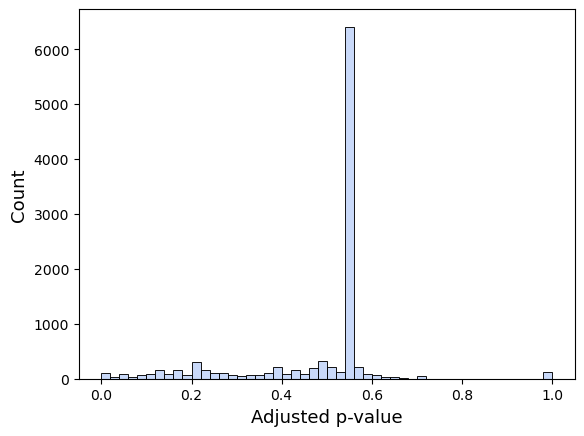

In [12]:
sns.histplot(adjusted_pval, bins = 50,color='#B8CDF8',edgecolor="k") 

#plt.title('Metabolomic adjusted p-value distribution',fontsize=16)

plt.xlabel('Adjusted p-value',fontsize=13)
plt.ylabel('Count',fontsize=13) 

#plt.savefig( 'Figures/adjusted_pval_metabolomic.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [13]:
#Easier to obtain the reverse (i.e. edges that are not significant), since then they can be removed easily from the final correlation network
not_sig_edge_boolean = [not elem for elem in sig_edge_boolean]
sum(not_sig_edge_boolean )

10279

In [14]:
#Instead of a boolean, obtain the names of the significant edges
df = pd.read_csv('../Data/permutation_test_files_metabolomics/observed_tstats.csv', index_col=0)
#df = pd.read_csv('../Data/permutation_test_files_proteomics/observed_tstats.csv', index_col=0)
#df = pd.read_csv('../Data/permutation_test_files_integrated/observed_tstats.csv', index_col=0)
edgelist = df.index

sig_edges = list(compress(edgelist,sig_edge_boolean))
not_sig_edges = list(compress(edgelist,not_sig_edge_boolean))

In [ ]:
#Form a dictionary where the edges have been assigned p-values (so I can test significance of differentially expressed genes)

edgelist_tuple = []
for i in range(len(edgelist)):
    edge = edgelist[i].split(",")
    edge = (edge[0],edge[1][1:])
    edgelist_tuple.append(edge)
    
p_val_dict  = dict(zip(edgelist_tuple, adjusted_pval))

In [18]:
#Form a list of the number of edges differentially expressed in either the mild or severe group

sig_df = df.loc[sig_edges]
sigedge_direction = []

for i in range(len(sig_df)):
    if sig_df.Observed_tstat[i] > 0:
        sigedge_direction.append("mild")
    if sig_df.Observed_tstat[i] < 0:
        sigedge_direction.append("severe")

print(sigedge_direction.count("mild"))
print(sigedge_direction.count("severe"))

Saving the significant edges: Easier to compare with the naive networks and the other omics networks as well <br>
Saving the non-significant edges: Easier when constructing the differential networks

In [ ]:
 #with open ('../Data/permutation_test_files_metabolomics/sig_edges.txt', 'w') as file:
#     file.write(','.join(str(i) for i in sig_edges))
     
#with open ('../Data/permutation_test_files_metabolomics/not_sig_edges.txt', 'w') as file:
#     file.write(','.join(str(i) for i in not_sig_edges))

#with open ('../Data/permutation_test_files_metabolomics/sigedge_direction.txt', 'w') as file:
#     file.write(','.join(str(i) for i in sigedge_direction))

#----------------------------------------------------

#All edges with a p-value of zero:
#with open ('../Data/permutation_test_files_metabolomics/pval0_sig_edges.txt', 'w') as file:
#     file.write(','.join(str(i) for i in sig_edges))

#with open ('../Data/permutation_test_files_metabolomics/pval0_sigedge_direction.txt', 'w') as file:
#     file.write(','.join(str(i) for i in sigedge_direction))

### Plotting the test statistic distribution for randomly chosen pathway pairs


In [22]:
#Load libraries
import pandas as pd
import os
import random
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
#Download the observed test statistics
df = pd.read_csv('../Data/permutation_test_files_metabolomics/observed_tstats.csv', index_col=0)
#df = pd.read_csv('../Data/permutation_test_files_proteomics/observed_tstats.csv', index_col=0)
#df = pd.read_csv('../Data/permutation_test_files_integrated/observed_tstats.csv', index_col=0)

path = os.getcwd()[:-13] + '\\Data\\permutation_test_files_metabolomics'
#path = os.getcwd()[:-13] + '\\Data\\permutation_test_files_proteomics'
#path = os.getcwd()[:-13] + '\\Data\\permutation_test_files_integrated'

Read in the test distribution files that were made from the HPC and plotting:

Observed t-statistic is:  -0.294106431
100000
[0.16603189339812977, -0.3901716783627241, 0.12725071434345736, -0.18666891377307016, 0.201642626323118, -0.08962173442619947, 0.09168010854167086, 0.09997913688675741, 0.16816145511595082, -0.009953062512071842, -0.022257899072219978, -0.11258074298654827, 0.18934996758787898, 0.11588156775446787, -0.09060015663834897, 0.04157329049822156, -0.19580862711185162, 0.10763982694975321, -0.1373387504697937, -0.06043280508247789, -0.30707502099494133, 0.050634895872664454, -0.22797132470250978, -0.011852693820847915, -0.01337711597062291, 0.2676125878822145, 0.13069599742187032, -0.09723102817882917, -0.13451402972956744, 0.12570328272003542, 0.09341276632793372, -0.4514971454822022, 0.2693837085702044, -0.24048597809198935, 0.3162662932544791, 0.2462840792872068, -0.26783273690618603, 0.022436152093456452, -0.09179740041319856, -0.28141797462616935, -0.12401107207058959, -0.4825382725495517, -0.19556380883617908, 0.49737701953111235, -0.0292533

(0.0, 15000.0)

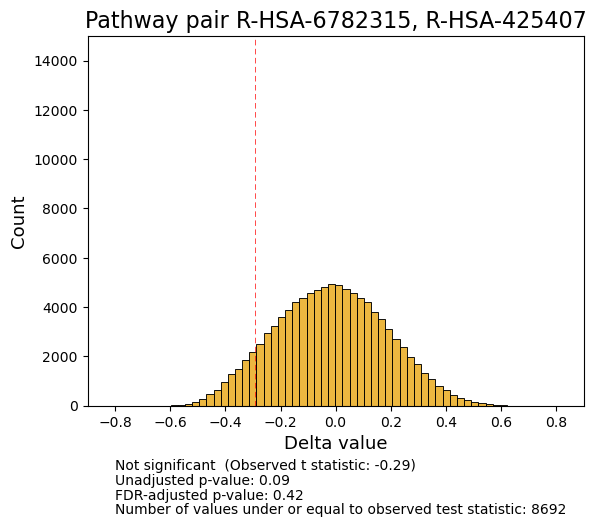

In [46]:
#Open the test distribution files one by one
test_num = 4631

with open('../Data/permutation_test_files_metabolomics/Test_distribution/test_distribution'+str(test_num)+'.txt') as file:
#with open('../Data/permutation_test_files_proteomics/Test_distribution/test_distribution'+str(test_num)+'.txt') as file:
#with open('../Data/permutation_test_files_integrated/Test_distribution/test_distribution'+str(test_num)+'.txt') as file:

    comparison = df.Observed_tstat[test_num]
    print("Observed t-statistic is: ", comparison)

    edge_name = df.index[test_num]

    lines = file.readlines()
    vals = lines[0].split(',')
    vals =  [float(x) for x in vals]
    print(len(vals))
    print(vals[:100])


sns.histplot(vals, bins = 50, color='#e69f00', edgecolor="k") 

plt.title('Pathway pair '+ edge_name,fontsize=16)
plt.xlabel('Delta value',fontsize=13)
plt.ylabel('Count',fontsize=13) 


#Plot observed t statistic lines
plt.axvline(x=comparison, color='r', linewidth=0.5, linestyle='--', dashes=(8, 5))


#Count number of values that are over/under the observed test statistic for two sided permutation test
counter = 0 
for index in range(len(vals)):  #len(final_list) = number of permutations
    if comparison >= 0:
        if vals[index] >= comparison:   
            counter += 1
    if comparison < 0:
        if vals[index] < comparison:   
            counter += 1
print(counter)


#MUST RUN THE ABOVE CODE TO LOAD IN 'sig_edge_boolean'
if sig_edge_boolean[test_num] == True:
    plt.text(-0.8, -2600, "Adjusted p-value significant",fontsize=10)
else:
    plt.text(-0.8, -2600, "Not significant"+ "  (Observed t statistic: "+str(round(comparison,2))+")", fontsize=10)
plt.text(-0.8, -3200, "Unadjusted p-value: " + str(round(pval_array[test_num],2)),fontsize=10)
plt.text(-0.8, -3800, "FDR-adjusted p-value: " + str(round(adjusted_pval[test_num],2)),fontsize=10)
plt.text(-0.8, -4400, "Number of values under or equal to observed test statistic: " + str(counter),fontsize=10)

plt.xlim(-0.9,0.9)   
plt.ylim(0,15000) 

#plt.savefig( 'Figures/Pathway ' + edge_name + '.png' ,dpi=200, bbox_inches = 'tight', pad_inches = 0.2, facecolor='w')